# Background
This notebook should help create all of the values that we use in the paper, correcting for the 1,000 scaling issue we caught

In [1]:
import os
os.chdir(os.pardir)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd
import math
import numpy as np

import vapor
from vapor.models import Cambium

2021-02-05 12:33:53,666 [MainThread  ] [INFO ]  Starting log for vapor...


In [2]:
os.getcwd()

'/lustre/eaglefs/projects/vapor/vapor-open'

### BNEF - existing results

In [3]:
# --- Load Regional Best ---
results = pd.read_pickle(os.path.join('results','bnef_results_newtb.pkl'))
results['scenario'] = 'Mid Cost'
results['batt_size'] = 0
results.rename({'geometry':'point', 'region':'pca'}, axis='columns', inplace=True)

In [4]:
# --- Merge on Regions ---
region_map = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
region_map = region_map[['pca','rto','census_reg','inter']].drop_duplicates()

census_reg_dict = {
    'PA':'West',
    'MTN':'West',
    'ENC':'Midwest',
    'WNC':'Midwest',
    'WSC':'South',
    'MA':'Northeast',
    'NE':'Northeast',
    'ESC':'South',
    'SA':'South'
}
region_map['census_div'] = region_map['census_reg'].map(census_reg_dict)

df = results.merge(region_map, on='pca', how='left')

In [5]:
years = [str(i) for i in range(2014,2051,1)]
cambium_cols = [i for i in df.columns if 'cambium' in i]
cambium_cols = [i for i in cambium_cols if i[-4:] in years]

# --- subset cambium columns ---
c_df = df[cambium_cols + list(region_map.columns) + ['project_id','tech','system_capacity', 'capacity_factor']]

# --- melt ---
c_df = c_df.melt(id_vars= list(region_map.columns) +['project_id','tech','system_capacity', 'capacity_factor'])
c_df['year'] = [int(i[-4:]) for i in c_df['variable']]
c_df['variable'] = [str(i[:-5]) for i in c_df['variable']]

c_df['value_mw'] = (c_df['value'] / c_df['system_capacity']) * 1000

### Focusing on year 2020
Here we correct the scaling issue for BNEF results

In [6]:
c_df_foc = c_df.loc[\
         (c_df['year'] == 2020)\
        ].sort_values('value_mw', ascending=False)
c_df_foc.value *= 1000 # CORRECTING SCALING VALUES
c_df_foc.head()

,pca,rto,census_reg,inter,census_div,project_id,tech,system_capacity,capacity_factor,variable,value,year,value_mw
6247,p37,rto11,WNC,eastern,Midwest,68792,wind,1600.0,46.757293,cambium_co2_rate_lrmer,6.003806e+06,2020,3752.378605
6307,p53,rto8,WNC,eastern,Midwest,76655,wind,178000.0,39.754586,cambium_co2_rate_lrmer,4.944923e+08,2020,2778.046373
6471,p53,rto8,WNC,eastern,Midwest,117962,wind,200000.0,39.769703,cambium_co2_rate_lrmer,5.548558e+08,2020,2774.278909
6576,p53,rto8,WNC,eastern,Midwest,136337,wind,200000.0,39.769703,cambium_co2_rate_lrmer,5.548558e+08,2020,2774.278909
6613,p53,rto8,WNC,eastern,Midwest,147503,wind,145000.0,39.724537,cambium_co2_rate_lrmer,4.006199e+08,2020,2762.896198


#### Abstract
Finding the total estimated emissions avoided and grid value for 2020, all regions and both technologies

In [7]:
results_temp = {'total_emissions_bnef': \
                {'units': 'metric tons',
                 'value': c_df_foc.loc[c_df_foc.variable == 'cambium_co2_rate_lrmer']['value'].sum()/1000},\
               'total_grid_value_bnef': \
                {'units': 'dollars',
                 'value': c_df_foc.loc[c_df_foc.variable == 'cambium_grid_value']['value'].sum()}\
               }

In [8]:
print(f"Total avoided emissions: {np.round(results_temp['total_emissions_bnef']['value']/1E6, decimals=2)} million {results_temp['total_emissions_bnef']['units']}")
print(f"Total grid value: {np.round(results_temp['total_grid_value_bnef']['value']/1E9, decimals=2)} billion {results_temp['total_grid_value_bnef']['units']}")

Total avoided emissions: 35.52 million metric tons
Total grid value: 2.32 billion dollars


In [43]:
c_df_foc.loc[c_df_foc.variable == 'cambium_co2_rate_lrmer']['value'].median()

2363565.0810583862

## Images
Originally created in the `viz_bnef_results.ipynb` notebook

### BNEF values - violin plots

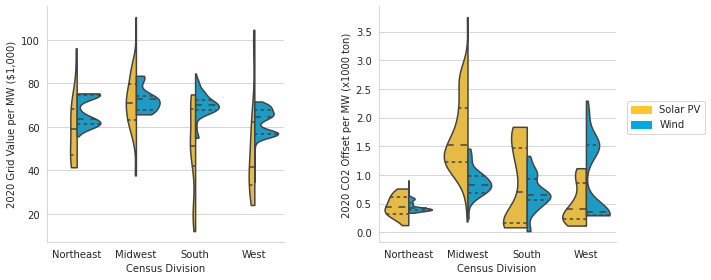

In [9]:
dist = c_df.copy()

# CORRECTING FOR SCALING ISSUE
dist[['value', 'value_mw']] *= 1000

sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

grid_value = dist.loc[(dist['variable'] == 'cambium_grid_value') & (dist['year'] == 2020)]
co2_lrmer = dist.loc[(dist['variable'] == 'cambium_co2_rate_lrmer') & (dist['year'] == 2020)]

# SETTING NEW UNITS OF TONS AND millions of dollars
# originally divided by a thousand to get the original thousands of dollars and metric tons units
grid_value[['value', 'value_mw']] /= 1E3
co2_lrmer[['value', 'value_mw']] /= 1E6

sns.set_palette(sns.color_palette([vapor.tech_dict['pv'], vapor.tech_dict['wind']]))

sns.violinplot(
    data=grid_value, x='census_div', y='value_mw',
    hue='tech', split=True, inner='quart',
    ax=ax1, cut=0, scale='area'
  )

sns.violinplot(
    data=co2_lrmer, x='census_div', y='value_mw',
    hue='tech', split=True, inner='quart', 
    ax=ax2, cut=0, scale='width'
  )

ax1.set_ylabel('2020 Grid Value per MW ($1,000)')
ax2.set_ylabel('2020 CO2 Offset per MW (x1000 ton)')
ax1.set_xlabel('Census Division')
ax2.set_xlabel('Census Division')

ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)

label_dict = {'pv':'Solar PV', 'wind':'Wind'}
custom_patches = [mpatches.Patch(color=vapor.tech_dict[k], label=v) for k,v in label_dict.items()]
plt.legend(handles=custom_patches, bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
sns.despine()

In [10]:
print(f"grid value raw in $: {dist.loc[(dist['variable'] == 'cambium_grid_value') & (dist['year'] == 2020)].value.sum()}")
print(f"grid value in $1,000: {grid_value.value.sum()}")
print(f"emissions raw in kg: {dist.loc[(dist['variable'] == 'cambium_co2_rate_lrmer') & (dist['year'] == 2020)].value.sum()}")
print(f"emissions in 1,000 tons: {co2_lrmer.value.sum()}")

grid value raw in $: 2322272215.9761662
grid value in $1,000: 2322272.2159761665
emissions raw in kg: 35522650674.45915
emissions in 1,000 tons: 35522.65067445915


### Regional values, supply curves

In [3]:
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['project_return_aftertax_npv']#['marginal_cost_mwh']
scenarios = ['StdScen20_HighRECost', 'StdScen20_LowRECost', 'StdScen20_MidCase']
techs = ['pv', 'wind']
batt_sizes = [0., 25., 100.]
batt_durations = [4.]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for batt_size in batt_sizes:
                for batt_duration in batt_durations:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_batt_{batt_size}_{batt_duration}.pkl"
                    fp = os.path.join('results',file)
                    dfs.append(pd.read_pickle(fp))


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

# --- Map on States ---
hierarchy = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
hierarchy.rename({'pca':'region'}, axis='columns', inplace=True)
df = results.merge(hierarchy[['region','state']], on='region', how='left')
                        
# --- Sort Systems to Keep best by State ---
df.sort_values(opt_vars[0], inplace=True)
df.drop_duplicates(['scenario','state','tech','batt_size'], inplace=True) #keep best performing system by region/scenario

# --- Clean up ---
df['lifetime_cambium_co2_rate_avg_mwh'] = df['lifetime_cambium_co2_rate_avg'] / df['lifetime_output_mwh']
df['lifetime_cambium_co2_rate_avg_mw'] = df['lifetime_cambium_co2_rate_avg'] / df['system_capacity']
df['lifetime_cambium_co2_rate_lrmer_mwh'] = df['lifetime_cambium_co2_rate_lrmer'] / df['lifetime_output_mwh']
df['lifetime_cambium_co2_rate_lrmer_mw'] = df['lifetime_cambium_co2_rate_lrmer'] / df['system_capacity']
df['lifetime_cambium_grid_value'] = df['lifetime_cambium_grid_value'] / df['system_capacity']

df.head()

,adjusted_installed_cost,analysis_period_irr,cash_for_debt_service,cbi_fedtax_total,cbi_statax_total,cbi_total,cbi_total_fed,cbi_total_oth,cbi_total_sta,cbi_total_uti,...,env_losses,ops_losses,turb_losses,wake_losses,wind_speed_average,turbine_class,wind_turbine_hub_ht,state,lifetime_cambium_co2_rate_avg_mw,lifetime_cambium_co2_rate_lrmer_mw
3092,2.751567e+08,NaN,-2.618369e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX,5093.072296,9319.837224
5228,2.751567e+08,NaN,-2.522835e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX,5631.630387,9154.598935
955,2.751567e+08,NaN,-2.433029e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX,6868.723315,11762.892953
4150,2.931684e+08,NaN,-1.787634e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.578702,2.803467,3.954496,11.930601,4.625302,4.0,139.235694,AR,1278.946134,1239.443375
3944,3.032650e+08,NaN,-1.659582e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.578702,2.803467,3.954496,20.077163,3.622347,4.0,139.235694,CA,1284.745408,786.081012


#### Checking lifetime generation values against expectations
Life time generation from Vapor (`lifetime_output_mwh`) is about half of estimates for lifetime generation calculated from capacity factor (* 8760 * 25 years). This can be accounted for by the degredation rate of 5% assumed for Vapor.

Generation seems to be ok!

In [36]:
temp_df_check_gen = df[['system_capacity', 'capacity_factor', 'lifetime_output_mwh']]
temp_df_check_gen['gen_calc'] = ((df.system_capacity/1000) * (df.capacity_factor/100) * 8760*25)
temp_df_check_gen['gen_diff'] = temp_df_check_gen['lifetime_output_mwh']/(temp_df_check_gen['gen_calc'])
temp_df_check_gen

,system_capacity,capacity_factor,lifetime_output_mwh,gen_calc,gen_diff
3092,100000,27.670121,3.398995e+06,6.059757e+06,0.560913
5228,100000,27.677756,3.400024e+06,6.061429e+06,0.560928
955,100000,27.683212,3.400780e+06,6.062623e+06,0.560942
4150,100000,4.113895,5.060472e+05,9.009431e+05,0.561686
3944,100000,5.360362,6.606957e+05,1.173919e+06,0.562812
...,...,...,...,...,...
242,100000,20.610617,2.477713e+06,4.513725e+06,0.548929
337,100000,20.783002,2.502850e+06,4.551477e+06,0.549898
223,100000,22.202999,2.674453e+06,4.862457e+06,0.550021
333,100000,21.070145,2.532471e+06,4.614362e+06,0.548824


In [38]:
temp_df_check_gen.gen_diff.quantile(q=[i/100 for i in range(101) if i % 25 ==0])

0.00    0.520795
0.25    0.546552
0.50    0.561314
0.75    0.568382
1.00    0.571276
Name: gen_diff, dtype: float64

#### Checking output scales
All annual values seem to be off by 100 **not** 1,000. This doesn't match expectations as we have not yet changed any of the values read in from pickle files. Compare below value with estimate for median avoided 20220 emissions from BNEF section above.

In [81]:
print(f"Regional results, median 2022 avoided emissions [unknown]:\n{df.cambium_co2_rate_lrmer_2022.median()}")
print(f"Corrected median 2020 BNEF avoided emissions:\n{c_df_foc.loc[c_df_foc.variable == 'cambium_co2_rate_lrmer']['value'].median()}")

Regional results, median 2022 avoided emissions [unknown]:
39926.37109355767
Corrected median 2020 BNEF avoided emissions:
2363565.0810583862


This _could_ be because we are dealing with different capacities here ... need to hold that constant ...
Results seem to indicate that _accounting for system capacities_ yields about a scaling difference of 1,000.
Attempt below:

In [97]:
print(f"Regional results, quartiles of ratio of 2022 avoided emissions to system capacity [unknown]:\n{((df.cambium_co2_rate_lrmer_2022)/(df.system_capacity)).quantile(q=[i/100 for i in range(101) if i % 25 == 0])}")
print("\n")
print(f"Corrected quartiles of ratio of 2020 BNEF avoided emissions to system capacity:\n{((c_df_foc.loc[c_df_foc.variable == 'cambium_co2_rate_lrmer']['value'])/(c_df_foc.loc[c_df_foc.variable == 'cambium_co2_rate_lrmer']['system_capacity'])).quantile(q=[i/100 for i in range(101) if i % 25 == 0])}")

Regional results, quartiles of ratio of 2022 avoided emissions to system capacity [unknown]:
0.00    0.003894
0.25    0.182847
0.50    0.399264
0.75    0.644097
1.00    1.701342
dtype: float64


Corrected quartiles of ratio of 2020 BNEF avoided emissions to system capacity:
0.00      19.221450
0.25     344.650532
0.50     560.294561
0.75    1201.041342
1.00    3752.378605
dtype: float64


#### Comparing lifetime avoided emissions
Note:
1. to get lifetime BNEF lifetime results, I will be using the median ratio of generation accounting for degredation and without accounting for degredation
2. I will be quartiles in both BNEF and Regional results
3. Dividing all values by 1,000,000 to make it easier to read
4. values relying on the df dataframe have multiple battery sizes which can also skew results
***
The below results indicate that the annual values (e.g., `_cambium_lrmer_2022`) need to be scaled, but that for some reason the lifetime values already account for this.

In [134]:
print("\n\n")
print("DIVIDING ALL RESULTS BY 1,000,000 to yield metric tons per MW")
print("\n\n")
print(f"Regional results single sample lifetime avoided emissions [Million tons/MW]:\n\n{((((df.lifetime_cambium_co2_rate_lrmer_mwh) * (df.lifetime_output_mwh))/(df.system_capacity))/1000000).quantile(q=[i/100 for i in range(101) if i % 25 == 0])}")
print("\n")
print(f"same as above but scaled (what we would EXPECT to work):\n\n{((((df.lifetime_cambium_co2_rate_lrmer_mwh) * (df.lifetime_output_mwh) * 1000)/(df.system_capacity))/1000000).quantile(q=[i/100 for i in range(101) if i % 25 == 0])}")
print("\n")
print(f"BNEF lifetime avoided emissions [Million tons/MW], accounting for degredation:\n\n{((((c_df_foc.loc[c_df_foc.variable == 'cambium_co2_rate_lrmer']['value'])/(c_df_foc.loc[c_df_foc.variable == 'cambium_co2_rate_lrmer']['system_capacity']))*(temp_df_check_gen.gen_diff.median()*25))/1E6).quantile(q=[i/100 for i in range(101) if i % 25 == 0])}")
print("\n")
print(f"Regional results manually calculating lifetime emissions:\n{(((df[[i for i in df.columns if 'cambium_co2_rate_lrmer_20' in i]].apply(sum, axis = 1))/df['system_capacity'])/1E6).quantile(q=[i/100 for i in range(101) if i % 25 == 0])}")
print("\n")
print(f"same as above but scaled [Million tons/MW] (what we would EXPECT to work):\n\n{(((df[[i for i in df.columns if 'cambium_co2_rate_lrmer_20' in i]].apply(sum, axis = 1)*1000)/df['system_capacity'])/1E6).quantile(q=[i/100 for i in range(101) if i % 25 == 0])}")




DIVIDING ALL RESULTS BY 1,000,000 to yield metric tons per MW



Regional results single sample lifetime avoided emissions [Million tons/MW]:

0.00    0.000279
0.25    0.003150
0.50    0.005622
0.75    0.008566
1.00    0.024442
dtype: float64


same as above but scaled (what we would EXPECT to work):

0.00     0.279085
0.25     3.149942
0.50     5.621599
0.75     8.565609
1.00    24.442142
dtype: float64


BNEF lifetime avoided emissions [Million tons/MW], accounting for degredation:

0.00    0.000270
0.25    0.004836
0.50    0.007863
0.75    0.016854
1.00    0.052657
dtype: float64


Regional results manually calculating lifetime emissions:
0.00    2.790854e-07
0.25    3.149942e-06
0.50    5.621599e-06
0.75    8.565609e-06
1.00    2.444214e-05
dtype: float64


same as above but scaled [Million tons/MW] (what we would EXPECT to work):

0.00    0.000279
0.25    0.003150
0.50    0.005622
0.75    0.008566
1.00    0.024442
dtype: float64


#### Comparing lifetime revenues
Note:
1. to get lifetime BNEF lifetime results, I will be using the median ratio of generation accounting for degredation and without accounting for degredation
2. I will be quartiles in both BNEF and Regional results
3. assuming same scaling issues for emissions (above) holder here: scale annual values, don't scale grid value

In [138]:
print("\n\n")
print(f"Regional results single sample lifetime revenues [$1,000's/MW]:\n\n{((((df.grid_value_per_mwh) * (df.lifetime_output_mwh))/(df.system_capacity))).quantile(q=[i/100 for i in range(101) if i % 25 == 0])}")
print("\n")
print(f"BNEF lifetime avoided emissions [$1,000's/MW], accounting for degredation:\n\n{((((c_df_foc.loc[c_df_foc.variable == 'cambium_grid_value']['value'])/(c_df_foc.loc[c_df_foc.variable == 'cambium_grid_value']['system_capacity']))*(temp_df_check_gen.gen_diff.median()*25))).quantile(q=[i/100 for i in range(101) if i % 25 == 0])}")
print("\n")
print(f"Regional results manually calculating lifetime grid value, scaled [$1,000's/MW] (what we would EXPECT to work):\n\n{(((df[[i for i in df.columns if 'cambium_grid_value_20' in i]].apply(sum, axis = 1)*1000)/df['system_capacity'])).quantile(q=[i/100 for i in range(101) if i % 25 == 0])}")




Regional results single sample lifetime revenues [$1,000's/MW]:

0.00      96.228860
0.25     539.505237
0.50     681.238683
0.75     813.381400
1.00    1154.408914
dtype: float64


BNEF lifetime avoided emissions [$1,000's/MW], accounting for degredation:

0.00     168.707165
0.25     837.736058
0.50     927.341245
0.75    1010.917713
1.00    1549.724194
dtype: float64


Regional results manually calculating lifetime grid value, scaled [$1,000's/MW] (what we would EXPECT to work):

0.00      96.228860
0.25     539.505237
0.50     681.238683
0.75     813.381400
1.00    1154.408914
dtype: float64


#### Adjusting values
Note: The marginal cost values should __not__ need to be adjusted as these did not appear in the `self.cambium.values` that seemed to be at the heart of the error. The values that __did__ fall into that problem are:
`{'cambium_co2_rate_avg', 'cambium_portfolio_value', 'cambium_busbar_energy_value', 'cambium_grid_value', 'cambium_co2_rate_lrmer', 'cambium_capacity_value'}`.
Based on results of above cells, we should not need to adjust the `grid_value_per_mwh` or `lifetime_cambium_co2_rate_lrmer_mwh` here either

Below code is based on code in `viz_supply_curves.py` and produces supply curve iamge

(0.0, 1000.0)

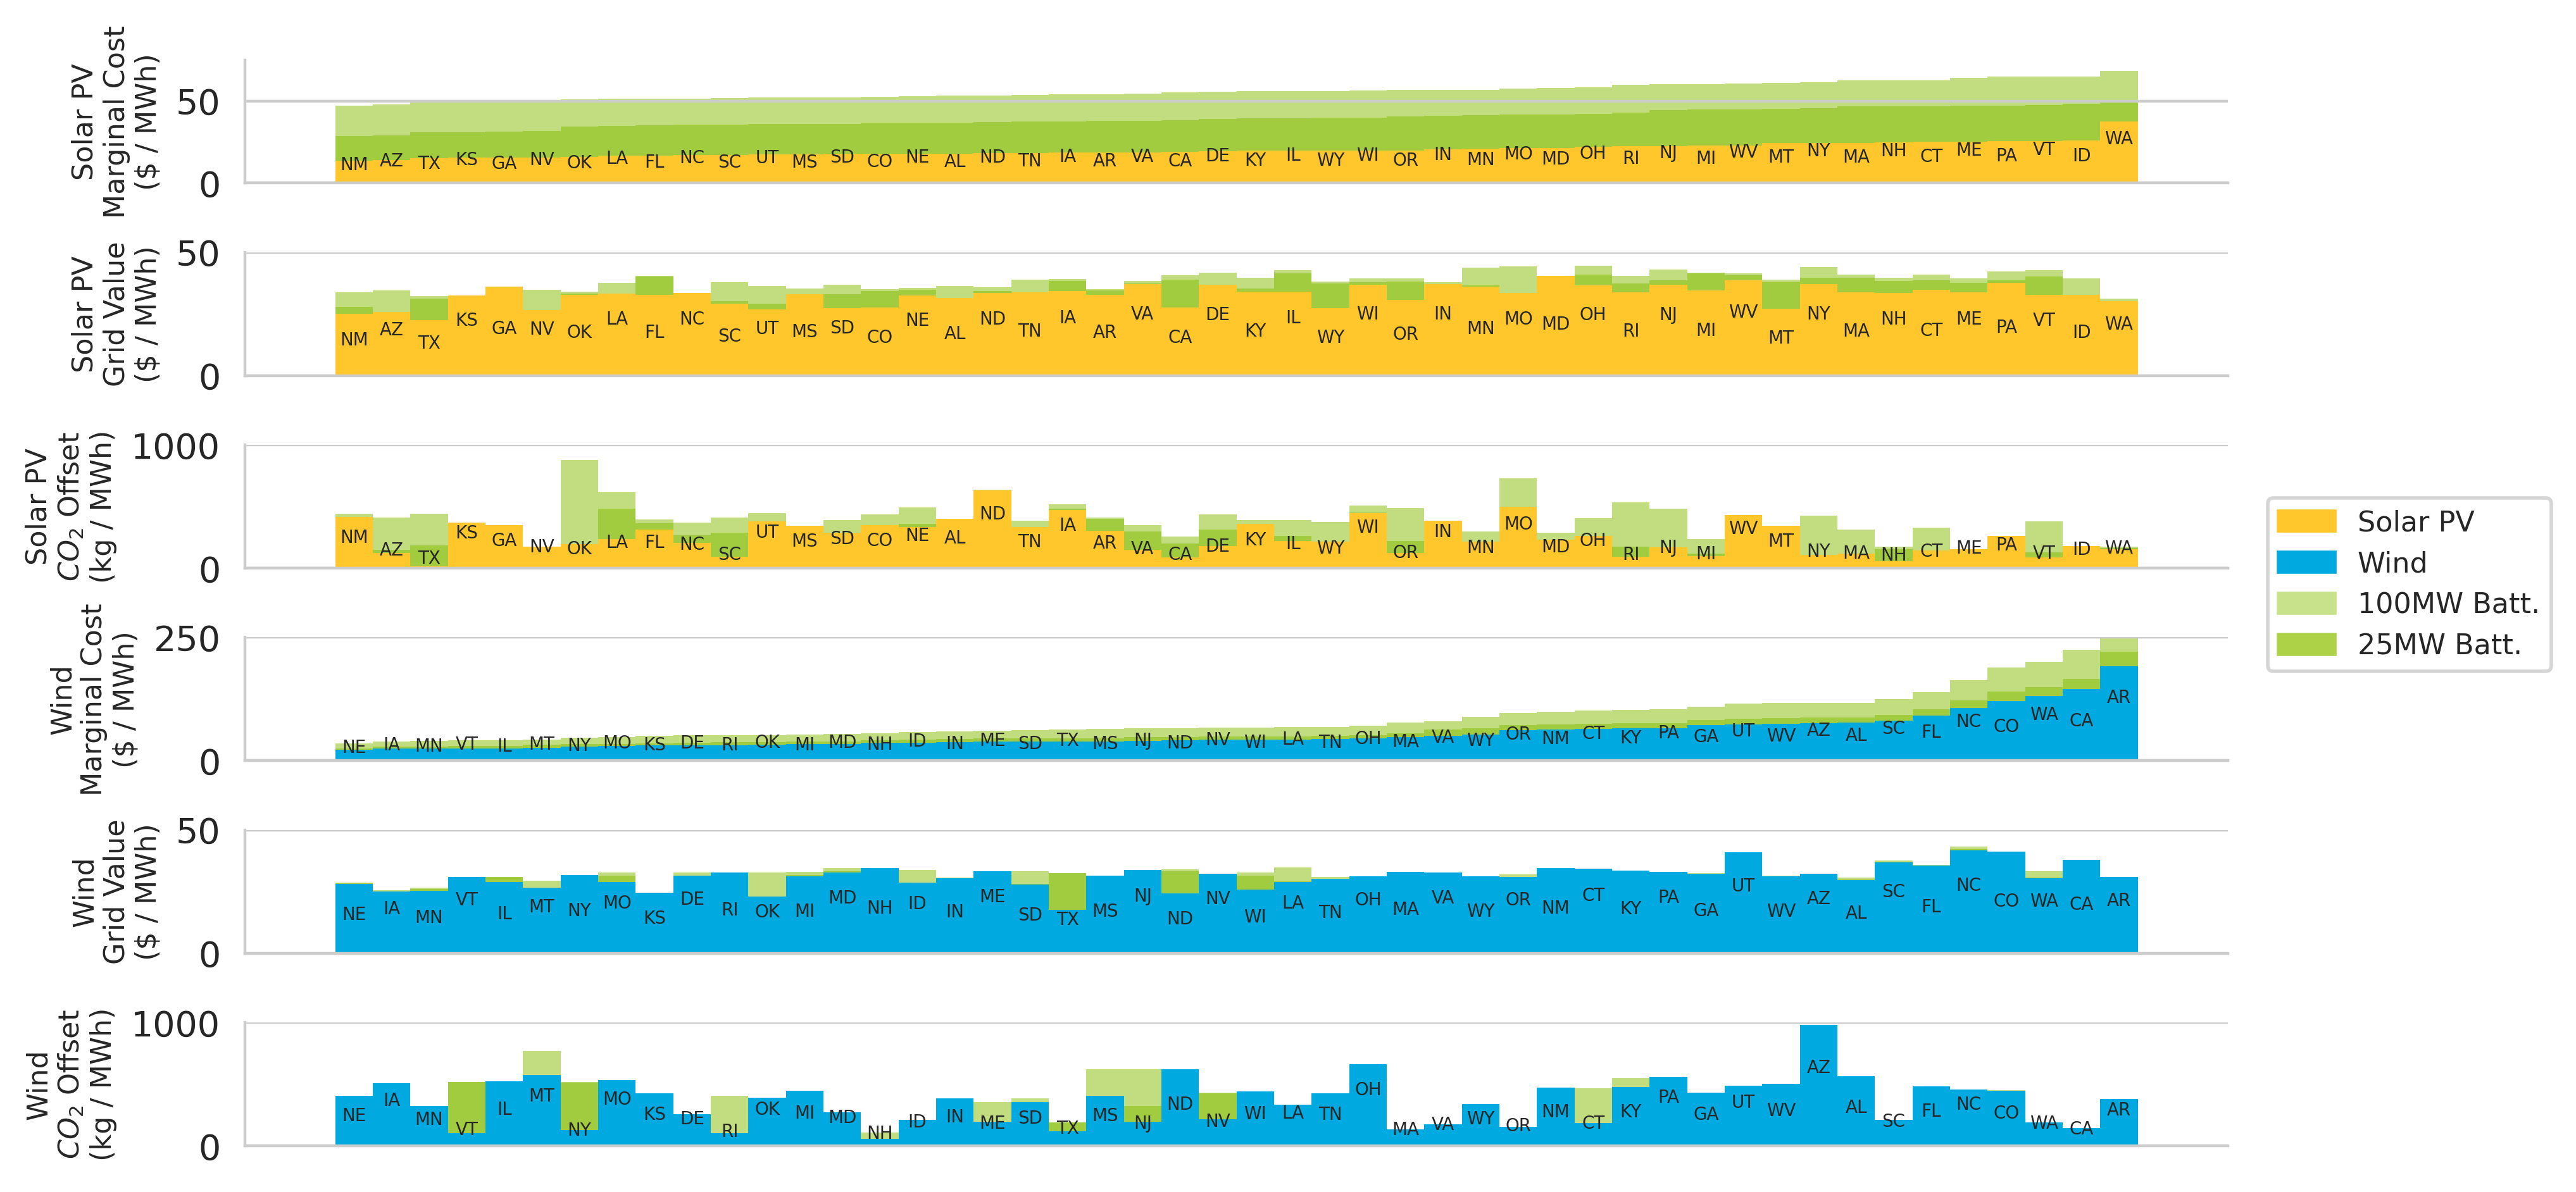

In [139]:
plot_df = df.copy()
opt_var = opt_vars[0]
plot_vars = ['marginal_cost_mwh',
             'grid_value_per_mwh',
             'lifetime_cambium_co2_rate_lrmer_mwh']
sort_var = plot_vars[0]
ascending=True
batt_sizes=[25,100]

label_dict = {
    'marginal_cost_mwh':'Marginal Cost\n($ / MWh)',
    'grid_value_per_mwh':'Grid Value\n($ / MWh)',
    'lifetime_cambium_grid_value_mw':'Grid Value\n($ / MW)',
    'lifetime_cambium_co2_rate_avg_mw':'$CO_2 (\overline{x})$ Offset\n(kg / MW)',
    'lifetime_cambium_co2_rate_avg_mwh':'$CO_2 (\overline{x})$ Offset\n(kg / MWh)',
    'lifetime_cambium_co2_rate_lrmer_mw':'$CO_2$ Offset\n(kg / MW)',
    'lifetime_cambium_co2_rate_lrmer_mwh':'$CO_2$ Offset\n(kg / MWh)'
}

tech_label_dict = {'pv':'Solar PV', 'wind':'Wind', 'batt25':'25MW Batt.', 'batt100':'100MW Batt.'}

nrel_color_dict = [
                '#0077C8', #darkblue
                '#00A9E0', #lightblue
                '#658D1B', #darkgreen
                '#84BD00', #lightgreen
                '#FFC72C', #yellow
                '#DE7C00', #orange
                '#5B6770', #darkgray
                '#C1C6C8' #lightgray
                ]

tech_dict = {'pv':nrel_color_dict[4],
            'wind':nrel_color_dict[1],
            'batt100':'#c8e28b',
            'batt25':'#add247'}


fig, axs = plt.subplots(nrows=len(plot_vars)*2, figsize=(9, 5), dpi=400, sharex=True)

axs_count = 0
for tech in ['pv','wind']:
    for plot_var in plot_vars:
        
        # --- subset scenario ---
        no_batt = plot_df.loc[(plot_df['scenario'] == scenario) & (plot_df['batt_size'] == 0) & (plot_df['tech'] == tech)]

        # --- drop duplicate techs for same state ---
        no_batt.sort_values(opt_var, ascending=ascending, inplace=True)
        no_batt.drop_duplicates(subset=['state', 'scenario'], inplace=True, keep='first')
        no_batt.sort_values(sort_var, ascending=ascending, inplace=True)

        # --- mock up widths and bar positions and color ---
        width = [i for i in no_batt['system_capacity']]

        relative_positions = []
        relative_position = 0
        previous_width = 0
        for w in width:
            relative_position = float(relative_position + (previous_width/2) + (w/2))
            previous_width = w
            relative_positions.append(relative_position)

        colors = no_batt['tech'].map(tech_dict)

        axs[axs_count].bar(relative_positions, no_batt[plot_var],
                    width=width, linewidth=0.0,
                    color=colors)

        # --- mock up label positions ---
        odd = -1
        for i, l in enumerate(no_batt['state']):
            x = relative_positions[i]
            y_max = list(no_batt[plot_var])[i]
            y =  y_max / 2 + (odd * y_max * 0.075)
            axs[axs_count].annotate(l, xy=(x,y), ha='center',va='bottom',
                                    fontsize=5)
            odd *= -1

        # --- plot battery bars ---
        if batt_sizes != None:
            for batt_size in batt_sizes:
                batt = plot_df.loc[(plot_df['scenario'] == scenario) & (plot_df['batt_size'] == batt_size) & (plot_df['tech'] == tech)]
                batt.sort_values(opt_var, ascending=ascending, inplace=True)
                batt.drop_duplicates(subset=['state', 'scenario'], inplace=True, keep='first')
                batt.sort_values(sort_var, ascending=ascending, inplace=True)

                axs[axs_count].bar(relative_positions, batt[plot_var],
                        width=width, linewidth=0.0, alpha=0.5,
                        color=nrel_color_dict[3], zorder=0)

        # --- clean up ---
#         plt.title(f'{scen_label_dict[scenario]}', fontsize=10)
        plt.subplots_adjust(hspace=0.5)
        axs[axs_count].set_ylabel(f"{tech_label_dict[tech]}\n{label_dict[plot_var]}", 
                                  fontsize=8)#, 
                                  #ha='right',
                                  #rotation=0
                                 #)
        plt.xlabel('')#Cumulative RE Capacity')
        axs_count += 1
        
        
plt.tight_layout()
custom_patches = [mpatches.Patch(color=v, label=tech_label_dict[k]) for k,v in tech_dict.items()]
axs[2].legend(handles=custom_patches, bbox_to_anchor=(1.02, 0.57), loc=2, borderaxespad=0., fontsize=8)

sns.despine(fig)

axs[5].set_xticks([], [])

axs[0].set_ylim(0,75)
axs[1].set_ylim(0,50)
axs[2].set_ylim(0,1000)
axs[3].set_ylim(0,250)
axs[4].set_ylim(0,50)
axs[5].set_ylim(0,1000)
    

#### General validation of supply curve image
This is just comparing values in the dataframe with the supply curve to make sure I did not miss something

In [150]:
plot_df_val = df.copy().loc[df.scenario == "StdScen20_MidCase"]
plot_df_val.groupby(['tech', 'batt_size'])['marginal_cost_mwh',\
                                           'grid_value_per_mwh',\
                                           'lifetime_cambium_co2_rate_lrmer_mwh'].quantile(q=[i/100 for i in range(101) if i % 25 == 0])

<ipython-input-150-a69d07eb16bc>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  plot_df_val.groupby(['tech', 'batt_size'])['marginal_cost_mwh',\


marginal_cost_mwh  grid_value_per_mwh  \
tech batt_size                                               
pv   0.0       0.00          13.523174           22.501554   
               0.25          17.372550           30.581198   
               0.50          19.574024           33.473739   
               0.75          22.682167           35.047205   
               1.00          37.488801           40.547213   
     25.0      0.00          28.545567           24.628905   
               0.25          36.086050           31.916043   
               0.50          39.176112           37.523315   
               0.75          44.455417           38.999707   
               1.00          48.916213           44.074436   
     100.0     0.00          47.263761           30.006219   
               0.25          51.993447           34.868414   
               0.50          55.658913           38.141386   
               0.75          60.140579           39.827756   
               1.00          68.105451           44.478919   
wind 0.0       0.00          21.685232           17.531345   
               0.25          33.075714           28.870186   
               0.50          42.575970           31.287738   
               0.75          67.264564           33.166113   
               1.00         191.587871           41.679187   
     25.0      0.00          25.261876           17.854462   
               0.25          38.355298           29.456202   
               0.50          49.469778           31.049583   
               0.75          77.735938           32.419514   
               1.00         220.526704           42.152691   
     100.0     0.00          35.402079           18.870201   
               0.25          52.868397           30.571367   
               0.50          67.318273           32.369735   
               0.75         105.282762           33.284091   
               1.00         291.683885           43.365420   

                     lifetime_cambium_co2_rate_lrmer_mwh  
tech batt_size                                            
pv   0.0       0.00                            18.082455  
               0.25                           146.679062  
               0.50                           226.896130  
               0.75                           349.491446  
               1.00                           633.918424  
     25.0      0.00                            21.675476  
               0.25                           149.171660  
               0.50                           258.625176  
               0.75                           368.324183  
               1.00                           729.579748  
     100.0     0.00                            66.931642  
               0.25                           171.192156  
               0.50                           313.229064  
               0.75                           436.624728  
               1.00                           876.007633  
wind 0.0       0.00                            58.059281  
               0.25                           193.613241  
               0.50                           386.122876  
               0.75                           478.079178  
               1.00                           977.786575  
     25.0      0.00                            57.687928  
               0.25                           191.450306  
               0.50                           372.023089  
               0.75                           466.354349  
               1.00                           769.591392  
     100.0     0.00                            57.268712  
               0.25                           190.092323  
               0.50                           363.637818  
               0.75                           466.028329  
               1.00                           976.664028

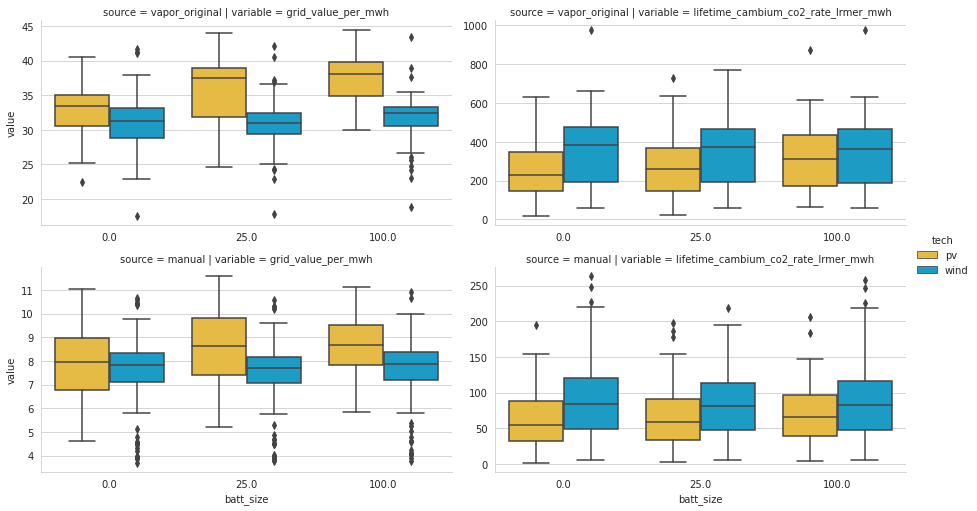

In [211]:
plot_df_val = df.copy().loc[df.scenario == "StdScen20_MidCase"]
plot_df_val = plot_df_val[['tech', 'batt_size',\
                           'grid_value_per_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']]
plot_df_val = plot_df_val.melt(id_vars=['tech', 'batt_size'],\
                 value_vars=['grid_value_per_mwh',\
                             'lifetime_cambium_co2_rate_lrmer_mwh'],\
                 var_name='variable', value_name='value')

plot_df_val['source'] = 'vapor_original'


manual_calc = pd.DataFrame({\
                'grid_value_per_mwh': (df[[i for i in df.columns if 'cambium_grid_value_20' in i]].apply(sum, axis = 1))*1000,\
                'lifetime_cambium_co2_rate_lrmer_mwh': (df[[i for i in df.columns if 'cambium_co2_rate_lrmer_20' in i]].apply(sum, axis = 1))*1000,
                'generation_mwh': (df['system_capacity']/1000)*(df['capacity_factor'])*(8760)*(temp_df_check_gen.gen_diff.median()),\
                'tech': df['tech'], 'batt_size': df['batt_size'],\
                'source': "manual"
})

manual_calc['grid_value_per_mwh'] = (manual_calc['grid_value_per_mwh'])/manual_calc['generation_mwh']
manual_calc['lifetime_cambium_co2_rate_lrmer_mwh'] = (manual_calc['lifetime_cambium_co2_rate_lrmer_mwh'])/manual_calc['generation_mwh']
manual_calc.drop(columns = ['generation_mwh'], inplace=True)

manual_calc = manual_calc.melt(id_vars=['tech', 'batt_size', "source"],\
                 value_vars=['grid_value_per_mwh',\
                             'lifetime_cambium_co2_rate_lrmer_mwh'],\
                 var_name='variable', value_name='value')

g = sns.catplot(x='batt_size', y='value',
                hue='tech', col='variable', row = 'source',
               data=pd.concat([plot_df_val, manual_calc]), kind='box',
               height=3.5, aspect=1.8, sharex = False, sharey=False)

## Chloropleths

In [44]:
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['project_return_aftertax_npv']#['marginal_cost_mwh']
scenarios = ['StdScen20_HighRECost', 'StdScen20_LowRECost', 'StdScen20_MidCase']
techs = ['pv', 'wind']
batt_sizes = [0., 25., 100.]
batt_durations = [4.]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for batt_size in batt_sizes:
                for batt_duration in batt_durations:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_batt_{batt_size}_{batt_duration}.pkl"
                    fp = os.path.join('results',file)
                    dfs.append(pd.read_pickle(fp))


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

# --- Map on States ---
hierarchy = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
hierarchy.rename({'pca':'region'}, axis='columns', inplace=True)
df = results.merge(hierarchy[['region','state']], on='region', how='left')
                        
# --- Sort Systems to Keep best by State ---
df.sort_values(opt_vars[0], inplace=True)
# df.drop_duplicates(['scenario','state','tech','batt_size'], inplace=True) #keep best performing system by region/scenario

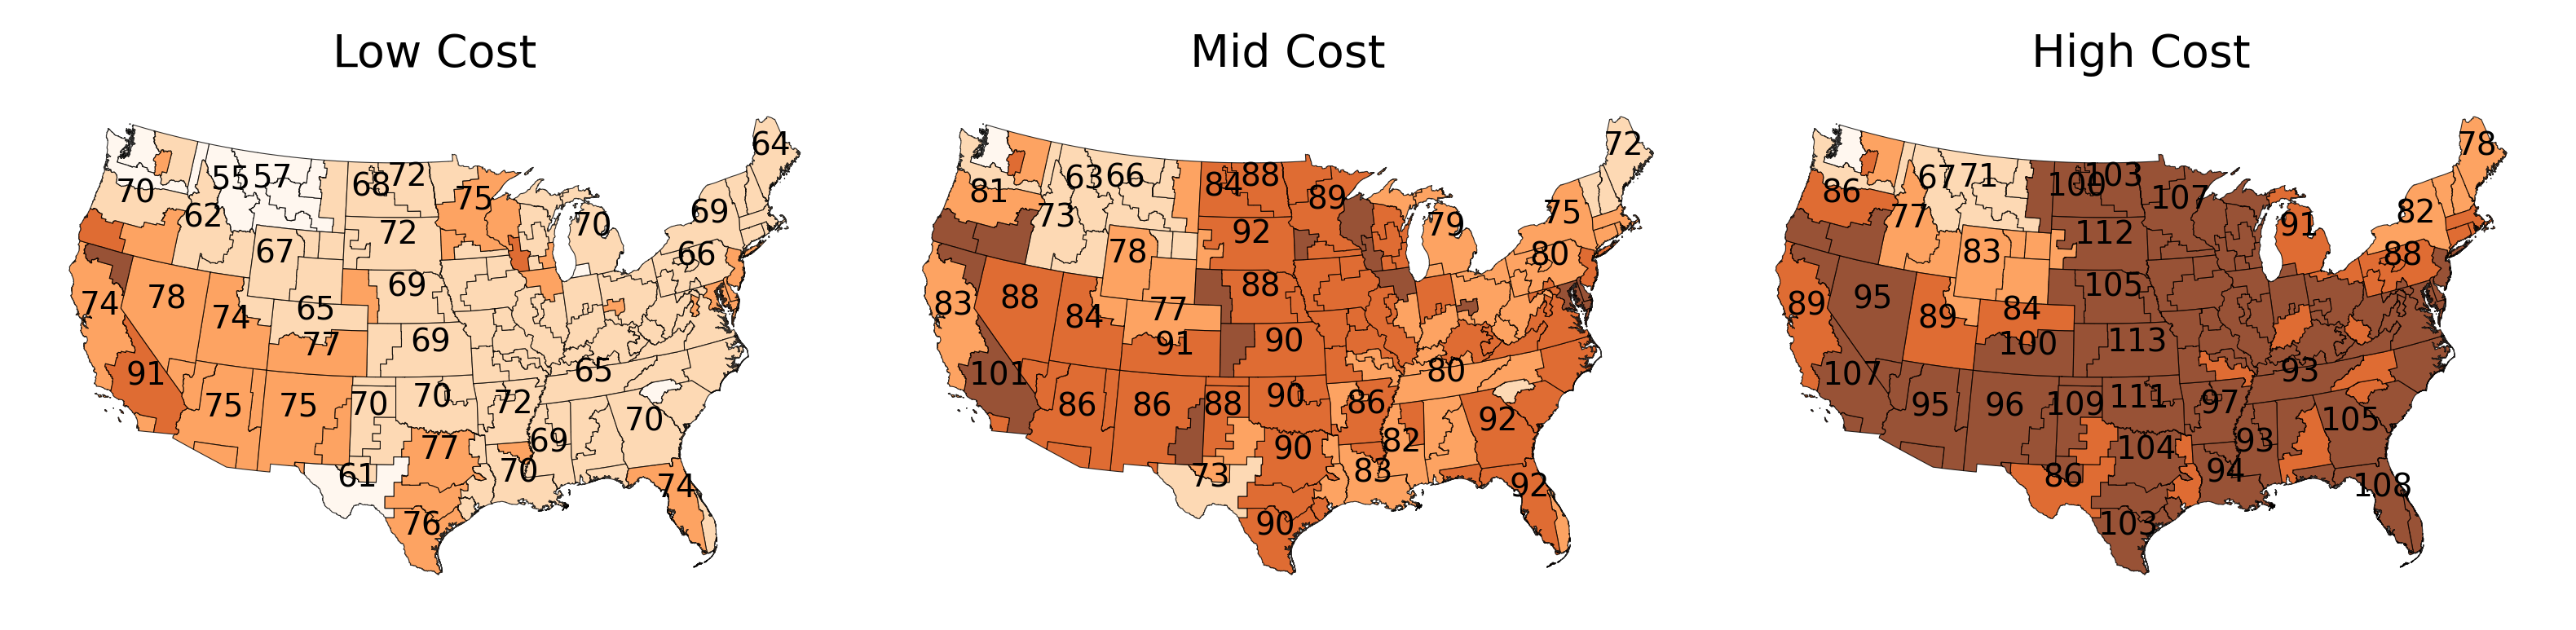

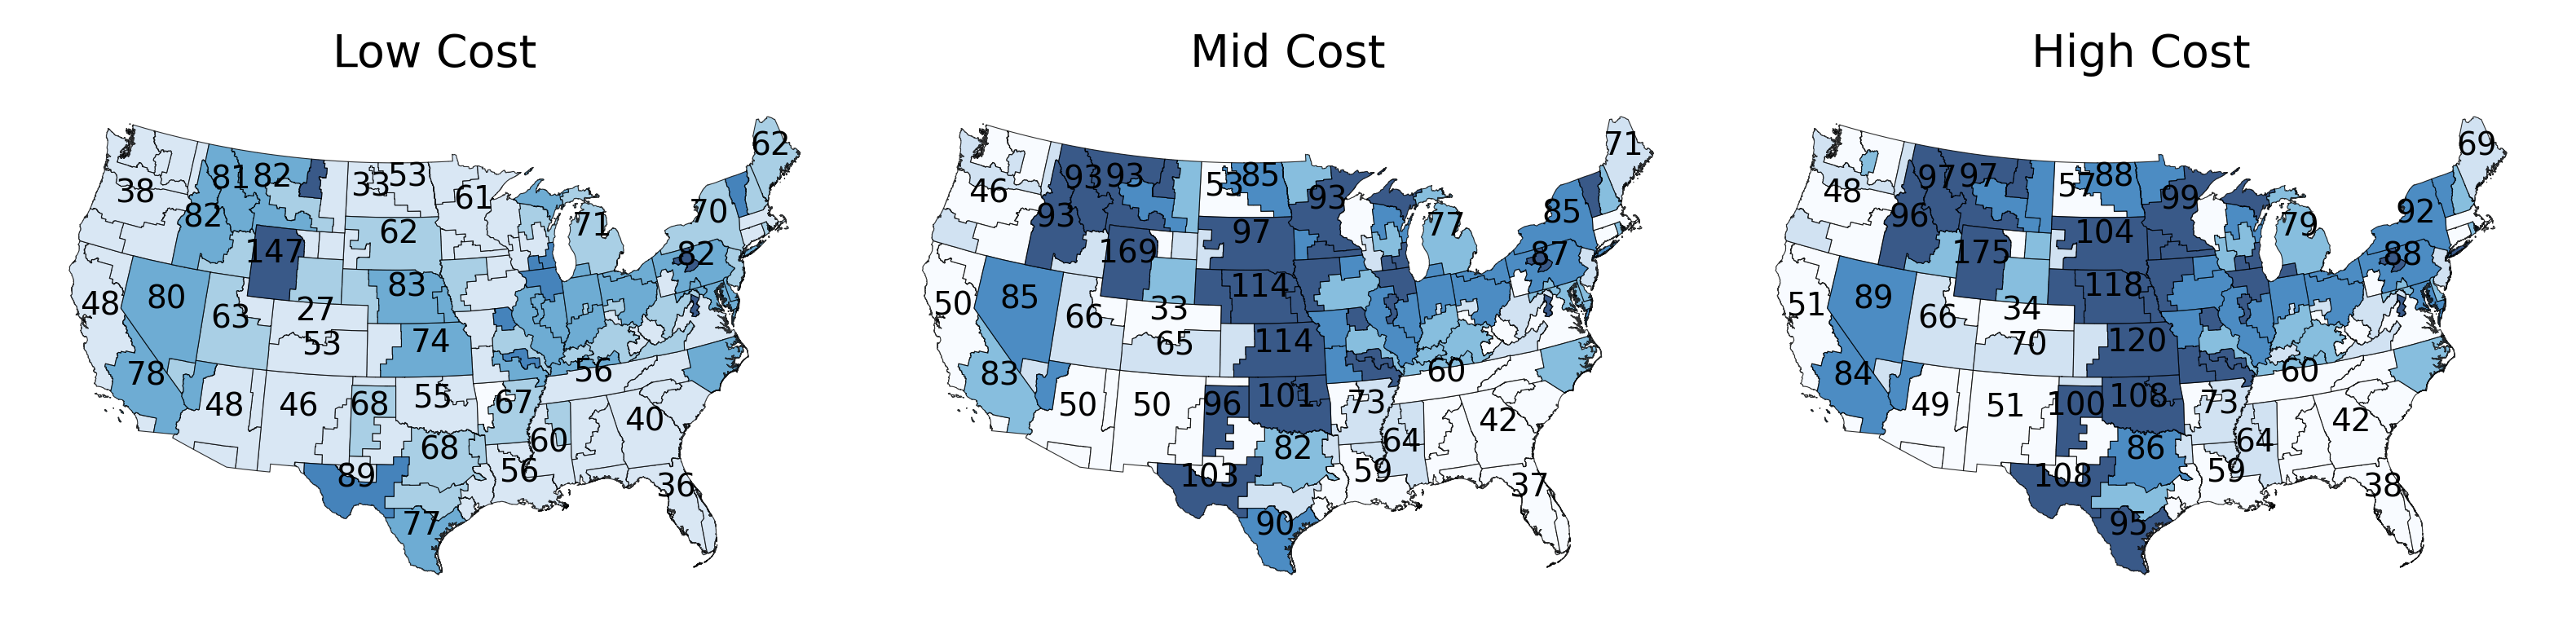

In [45]:
# --- Create Viz object ---
Viz = vapor.Visualizer(results=df, aggregate_region=aggregate_region, region_label_pct=0.75)
plot_df = Viz.gdf

Viz.triple_choropleth(column='lifetime_cambium_grid_value',
               tech='pv',
               ascending=True, reverse_cmap=False)

Viz.triple_choropleth(column='lifetime_cambium_grid_value',
               tech='wind',
               ascending=True, reverse_cmap=False)

In [68]:
grid_val_chl = plot_df.copy().loc[(plot_df.scenario == 'StdScen20_MidCase') & (plot_df.tech == 'wind') & (plot_df.batt_size == 0)]
grid_val_chl.sort_values(['lifetime_cambium_grid_value'], ascending=True, inplace=True)
grid_val_chl.drop_duplicates(subset=['region'], keep='first', inplace=True)
grid_val_chl = grid_val_chl[['region', 'lifetime_output_mwh', 'lifetime_cambium_grid_value']]
grid_val_chl.lifetime_cambium_grid_value = grid_val_chl.lifetime_cambium_grid_value/1E6
grid_val_chl

,region,lifetime_output_mwh,lifetime_cambium_grid_value
4282,p56,5.315050e+05,16.400461
30,p1,7.549546e+05,22.987992
643,p11,6.778937e+05,25.693332
2900,p33,7.968890e+05,32.925989
5525,p89,1.224651e+06,36.308815
...,...,...,...
3487,p41,4.054380e+06,108.198846
3461,p40,4.096096e+06,113.590202
4161,p53,4.412553e+06,113.738478
2245,p19,3.975610e+06,115.725231


In [42]:
grid_val_chl.lifetime_cambium_grid_value.quantile(q=[i/100 for i in range(101) if i % 25 == 0])

0.00     9.622886
0.25    48.052145
0.50    60.560978
0.75    66.844079
1.00    78.243630
Name: lifetime_cambium_grid_value, dtype: float64

In [48]:
cutoffs = plot_df['lifetime_cambium_grid_value'].quantile(list(np.arange(0,1,0.2))).to_list()
classification_kwds = dict(bins=cutoffs)
classification_kwds

{'bins': [9622886.031006485,
  59008614.54576896,
  70609610.12495592,
  79944698.39317967,
  90902963.69578686]}

<AxesSubplot:>

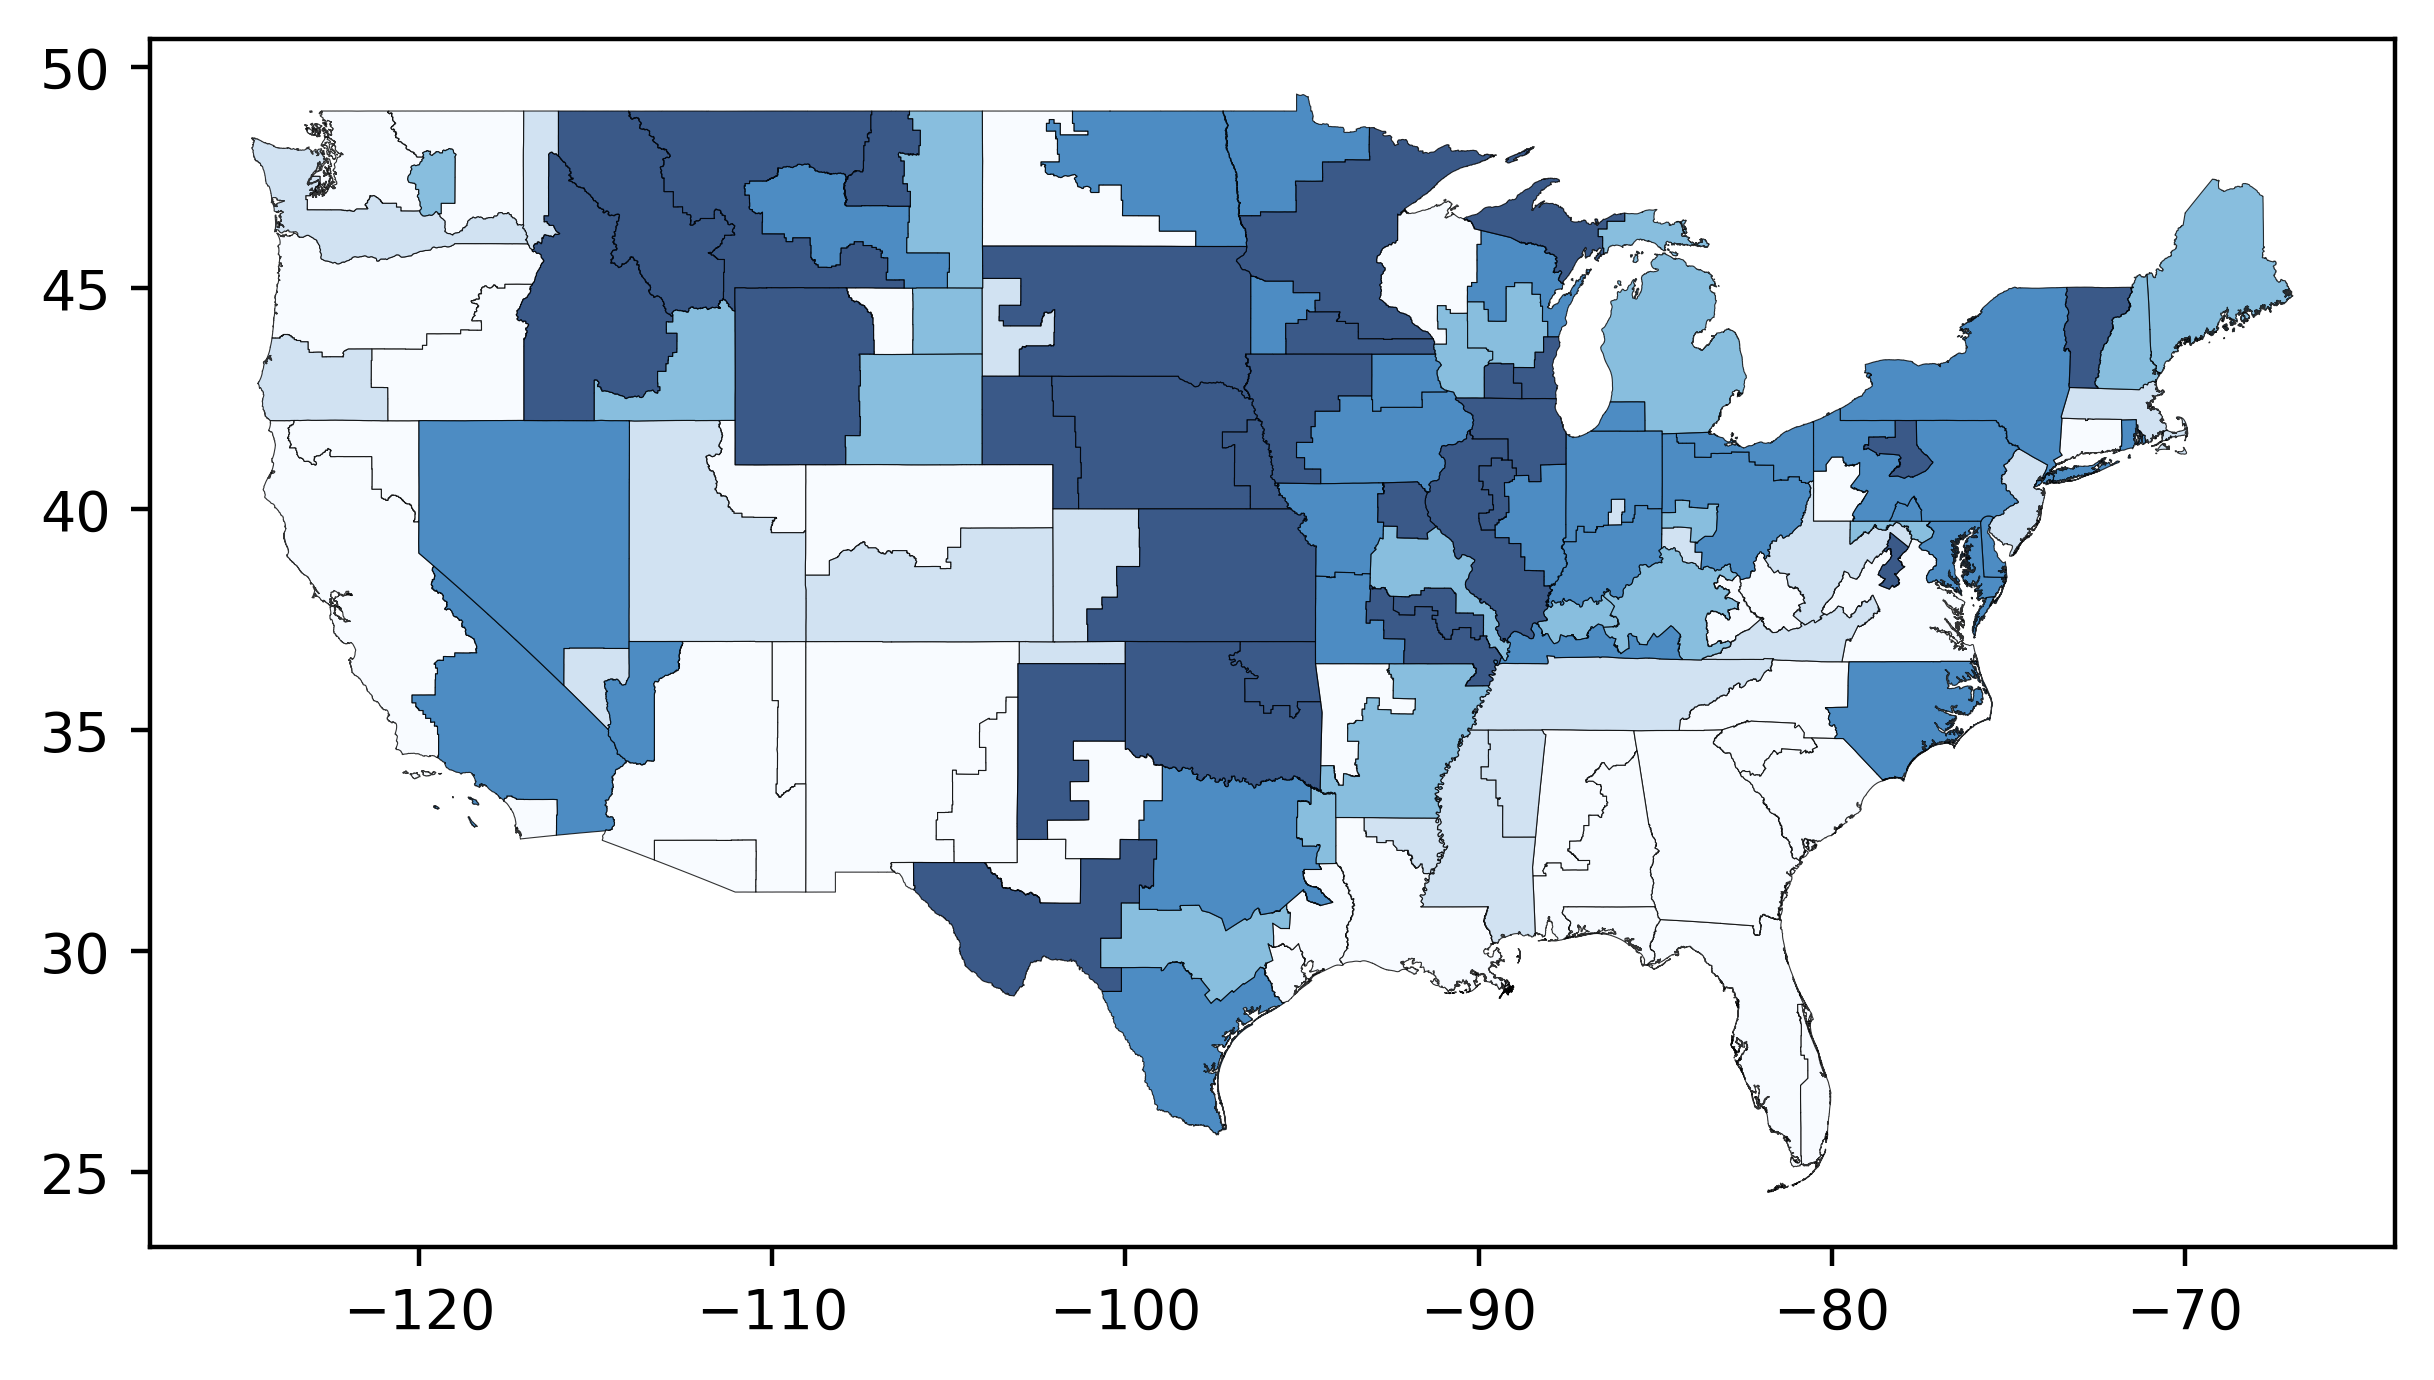

In [60]:
fig, ax = plt.subplots(figsize=(8,4), dpi=400, ncols=1)
temp = plot_df.copy().loc[(plot_df.scenario == 'StdScen20_MidCase') & (plot_df.tech == 'wind') & (plot_df.batt_size == 0)]
temp.sort_values(['lifetime_cambium_grid_value'], ascending=True, inplace=True)
temp.drop_duplicates(subset=['region'], keep='first', inplace=True)
temp.plot('lifetime_cambium_grid_value', edgecolor='k', cmap='Blues', alpha=0.8, linewidth=0.2, ax=ax,
                            scheme='UserDefined', classification_kwds=classification_kwds)

In [63]:
(temp.loc[temp.area.rank(pct=True) > 0.75]['lifetime_cambium_grid_value']/1E6).sort_values()

2900     32.925989
179      37.268242
6027     41.639198
3894     45.921484
2764     49.634525
2595     50.007273
5649     50.477277
4761     52.643780
3108     52.653496
4354     58.836611
5902     59.529433
3017     65.367666
2486     66.169785
1972     70.908876
5421     72.584077
2425     74.510615
329      76.743595
4552     82.009630
108      82.961766
3171     84.684164
1126     85.114933
1649     85.254870
1293     86.907245
4630     90.388399
2053     92.945982
2161     93.035925
3591     93.177124
2219     93.267056
3316     96.942054
3993    100.642922
4473    103.214044
3461    113.590202
4161    113.738478
2371    168.571911
Name: lifetime_cambium_grid_value, dtype: float64

In [65]:
xx = plot_df.copy().loc[(plot_df.scenario == 'StdScen20_MidCase') & (plot_df.tech == 'wind') & (plot_df.batt_size == 0)]
xx.sort_values(['lifetime_cambium_grid_value'], ascending=True, inplace=True)
xx.drop_duplicates(subset=['region'], keep='first', inplace=True)
(xx.lifetime_cambium_grid_value)/1E6

4282     16.400461
30       22.987992
643      25.693332
2900     32.925989
5525     36.308815
           ...    
3487    108.198846
3461    113.590202
4161    113.738478
2245    115.725231
2371    168.571911
Name: lifetime_cambium_grid_value, Length: 134, dtype: float64

In [73]:
xx = plot_df.copy().loc[(plot_df.scenario == 'StdScen20_MidCase') & (plot_df.tech == 'wind') & (plot_df.batt_size == 0)]
xx.sort_values(['lifetime_cambium_grid_value'], ascending=True, inplace=True)
xx.drop_duplicates(subset=['region'], keep='first', inplace=True)
(((xx[[i for i in df.columns if 'cambium_grid_value_20' in i]].apply(sum, axis = 1))*1000)/1E6).sort_values(ascending=True)

4282     16.400461
30       22.987992
643      25.693332
2900     32.925989
5525     36.308815
           ...    
3487    108.198846
3461    113.590202
4161    113.738478
2245    115.725231
2371    168.571911
Length: 134, dtype: float64

## Table 2 in paper

In [74]:
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['project_return_aftertax_npv']#['marginal_cost_mwh']
scenarios = ['StdScen20_HighRECost', 'StdScen20_LowRECost', 'StdScen20_MidCase']
techs = ['pv', 'wind']
batt_sizes = [0., 25., 100.]
batt_durations = [4.]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for batt_size in batt_sizes:
                for batt_duration in batt_durations:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_batt_{batt_size}_{batt_duration}.pkl"
                    fp = os.path.join('results',file)
                    dfs.append(pd.read_pickle(fp))


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

grouped = results.groupby(['scenario','tech','batt_size'], as_index=False)\
                [['grid_value_per_mwh',
                  'marginal_cost_mwh',
                  'lifetime_cambium_co2_rate_avg_mwh',
                  'lifetime_cambium_co2_rate_lrmer_mwh']].mean()
# grouped[['lifetime_cambium_co2_rate_avg','lifetime_cambium_grid_value']] /= 1e6

rename_dict = {'StdScen20_HighRECost':'High Cost', 'StdScen20_MidCase':'Mid Cost', 'StdScen20_LowRECost':'Low Cost'}

grouped['scenario'] = grouped['scenario'].map(rename_dict)
grouped['scenario'] = pd.Categorical(grouped['scenario'], categories=['Low Cost', 'Mid Cost', 'High Cost'], ordered=True)

tech_dict = {'pv':'PV', 'wind':'Wind'}
grouped['tech'] = grouped['tech'].map(tech_dict)

grouped.sort_values(['scenario','tech','batt_size'], inplace=True)
grouped.rename(columns = {'scenario':'Scenario',
                          'tech':'Tech',
                          'batt_size':'Batt Size (MW)', 
                          'grid_value_per_mwh': 'Grid Value ($ / MWh)', 
                          'lifetime_cambium_co2_rate_avg_mwh': 'Average Avoided CO2 (lbs / MWh)',
                         'lifetime_cambium_co2_rate_lrmer_mwh': 'LRMER Avoided CO2 (lbs / MWh)',
                         'marginal_cost_mwh': "Marginal Cost ($/MWh)"}, inplace=True)
grouped.to_csv(os.path.join('images','supply_curve_table_newtb.csv'))
grouped


,Scenario,Tech,Batt Size (MW),Grid Value ($ / MWh),Marginal Cost ($/MWh),Average Avoided CO2 (lbs / MWh),LRMER Avoided CO2 (lbs / MWh)
6,Low Cost,PV,0.0,27.714195,20.364619,220.159194,210.212906
7,Low Cost,PV,25.0,30.820472,39.717529,223.895995,218.882709
8,Low Cost,PV,100.0,32.555585,55.357104,230.748944,246.345462
9,Low Cost,Wind,0.0,26.374207,42.582606,212.699452,278.100673
10,Low Cost,Wind,25.0,26.032054,49.156747,210.374133,272.250730
11,Low Cost,Wind,100.0,26.622324,66.670415,209.487271,269.823035
12,Mid Cost,PV,0.0,33.283766,18.939654,268.130004,290.056015
13,Mid Cost,PV,25.0,36.069624,38.402482,271.449042,299.306336
14,Mid Cost,PV,100.0,37.517386,54.217785,276.448539,329.886522
15,Mid Cost,Wind,0.0,30.543849,41.406993,265.168604,369.523144


In [83]:
temp = results.copy()
temp['grid_value_total'] = (temp[[i for i in df.columns if 'cambium_grid_value_20' in i]].apply(sum, axis = 1))*1000
temp['emissions_total'] = (temp[[i for i in df.columns if 'cambium_co2_rate_lrmer_20' in i]].apply(sum, axis = 1))*1000
temp = temp[['scenario','tech','batt_size', 'grid_value_total', 'emissions_total', 'lifetime_output_mwh']]
temp['grid_value_total'] = temp['grid_value_total']/temp['lifetime_output_mwh']
temp['emissions_total'] = temp['emissions_total']/temp['lifetime_output_mwh']

temp = temp.groupby(['scenario','tech','batt_size'], as_index=False)\
                [['grid_value_total',
                  'emissions_total']].mean()
temp.sort_values(['scenario', 'tech', 'batt_size'])

,scenario,tech,batt_size,grid_value_total,emissions_total
0,StdScen20_HighRECost,pv,0.0,38.164606,355.296804
1,StdScen20_HighRECost,pv,25.0,40.279885,362.480717
2,StdScen20_HighRECost,pv,100.0,40.870225,385.634282
3,StdScen20_HighRECost,wind,0.0,31.229321,419.086236
4,StdScen20_HighRECost,wind,25.0,31.345425,414.264457
5,StdScen20_HighRECost,wind,100.0,32.133603,412.559781
6,StdScen20_LowRECost,pv,0.0,27.714195,210.212906
7,StdScen20_LowRECost,pv,25.0,30.820472,218.882709
8,StdScen20_LowRECost,pv,100.0,32.555585,246.345462
9,StdScen20_LowRECost,wind,0.0,26.374207,278.100673
